In [930]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.utils import shuffle
import seaborn as sns 

In [2]:
# read data
data_describe = pd.read_csv("data/feature_descriptions.csv")
real_data = pd.read_csv("data/real_data.csv")
syn_data = pd.read_csv("data/synthetic_data.csv")

In [3]:
encode_dist_real = {}
encode_dist_syn = {}
for i in real_data.columns:
    encode_dist_real[i] = set(real_data.loc[:, i].values)
    encode_dist_syn[i] = set(syn_data.loc[:, i].values)
    if len(encode_dist_real[i]) < len(encode_dist_syn[i]):
        print(i)

tolazamide
glimepiride-pioglitazone


In [5]:
encoders = {} # a dict storing all encoder of each column
for i in real_data.columns:
    encoder = preprocessing.LabelEncoder()
    encoder.fit(np.hstack((real_data.loc[:, i], syn_data.loc[:, i])))
    encoders[i] = encoder

In [6]:
# a list of discrete props
discrete_props = ['race', 'gender', 'age',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       '_diag_1', '_diag_2', '_diag_3']

In [7]:
# by PCA, we find these dimensions are not related to any principle component
# So we teased them out
not_in_pc = ["chlorpropamide", "acetohexamide", "tolbutamide", "miglitol", "tolazamide", "glyburide-metformin", "glipizide-metformin"]

In [8]:
def encode(dataframe):
    """encode the input dataframe, return 2 numpy array, one of all discrete dimension, one of all continous features"""
    data_num = dataframe.shape[0]   
    discre = np.zeros(data_num).reshape(-1, 1)
    contin = np.zeros(data_num).reshape(-1, 1)
    for i in dataframe.columns:
        if i in not_in_pc: continue
        if i in discrete_props:
            codes = encoders[i].transform(dataframe.loc[:, i])
            discre = np.hstack((discre, codes.reshape(-1, 1)))
        else:
            codes = np.array(dataframe.loc[:, i])  
            contin = np.hstack((contin, codes.reshape(-1, 1)))
        
    return discre[:, 1:], contin[:, 1:]

def encode_all(dataframe):
    """encode the input dataframe, return 1 numpy of all dimensions except those dimension in the list 'not_in_pc' """
    data_num = dataframe.shape[0]   
    res = np.zeros(data_num).reshape(-1, 1)
    for i in dataframe.columns:
        if i in not_in_pc: continue
        if i in discrete_props:
            codes = encoders[i].transform(dataframe.loc[:, i])
            res = np.hstack((res, codes.reshape(-1, 1)))
        else:
            codes = np.array(dataframe.loc[:, i])  
            res = np.hstack((res, codes.reshape(-1, 1)))
        
    return res[:, 1:]

In [9]:
# Encode data and shuffle data
# Here the labels is showing which is real data, which is synthetic data
# Real data - 0, Synthetic data - 1

all_data_discre, all_data_contin = encode(pd.concat([real_data, syn_data]))
all_data = encode_all(pd.concat([real_data, syn_data]))
labels = np.array([0] * real_data.shape[0] + [1] * syn_data.shape[0])
all_data, all_data_discre, all_data_contin, labels = shuffle(all_data, all_data_discre, all_data_contin, labels, random_state=10)

In [17]:
# try kpca to decouple the data
# the result is not so helpful
kpca = KernelPCA(10, kernel = "rbf")
kpca.fit(all_data[:5000, :])
data_kpca = kpca.transform(all_data[:10000, :])

In [18]:
# try t-SNE to decouple the data

tsne = TSNE(3)#, perplexity = 30, learning_rate = 500)
data_kpca.shape

(10000, 10)

In [19]:
mask1 = np.random.choice(all_data.shape[0], 10000, replace = False)
all_data_tsne = tsne.fit_transform(data_kpca)

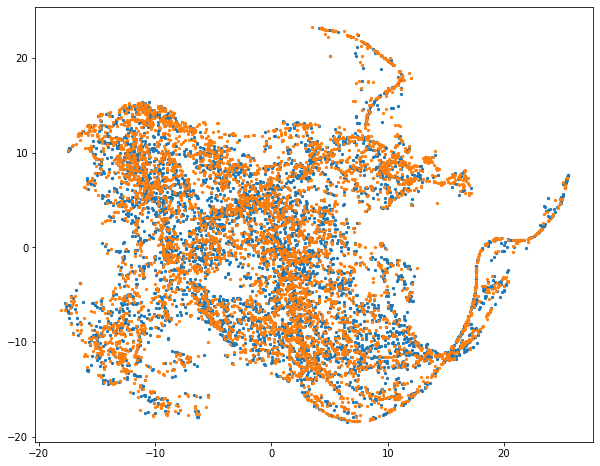

In [24]:
# shows that these dimensions are coupled
# the distribution of 2 dataset is not distinguishable

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.scatter(all_data_tsne[labels[:10000] == 0, 0], all_data_tsne[labels[:10000] == 0, 1], s = 5)
plt.scatter(all_data_tsne[labels[:10000] == 1, 0], all_data_tsne[labels[:10000] == 1, 1], s = 5)
plt.show()

## The code below try to train a model to distinguish 2 datasets

In [436]:
### Use Neruron Network to classify those two dataset
### And the accuracy as really hign (88% on test set)
### So this model of NN can de-couple those dimensions and uses them to classify 2 datasets pretty well

#mlp = MLPClassifier([60, 40, 20, 5], activation="relu", max_iter=500, verbose=True)
mlp = MLPClassifier([60, 40, 20, 10, 5], activation="relu", max_iter=500, verbose=True)
rf = RandomForestClassifier(max_depth = 20)
svc = SVC(kernel = "rbf", verbose=True)

# data and model
model = mlp


data_ = all_data
labels_ = labels


kf = KFold(2, shuffle = True)
acc_test_mlp = []
acc_train_mlp = []
res = np.zeros(1)
for train, test in kf.split(data_):
    model = mlp
    model.fit(data_[train], labels_[train])
    out_train = model.predict(data_[train])
    out_test = model.predict(data_[test])
    
    acc_test_mlp.append(np.sum(out_test == labels[test]) / labels[test].shape[0])
    acc_train_mlp.append(np.sum(out_train == labels[train]) / labels[train].shape[0])

Iteration 1, loss = 0.66701346
Iteration 2, loss = 0.60603090
Iteration 3, loss = 0.58642851
Iteration 4, loss = 0.57277792
Iteration 5, loss = 0.56058156
Iteration 6, loss = 0.54879018
Iteration 7, loss = 0.53767469
Iteration 8, loss = 0.52693583
Iteration 9, loss = 0.51500955
Iteration 10, loss = 0.50405874
Iteration 11, loss = 0.49436601
Iteration 12, loss = 0.48704666
Iteration 13, loss = 0.47682542
Iteration 14, loss = 0.47155584
Iteration 15, loss = 0.46390427
Iteration 16, loss = 0.46001592
Iteration 17, loss = 0.45686292
Iteration 18, loss = 0.45278715
Iteration 19, loss = 0.45181020
Iteration 20, loss = 0.44949345
Iteration 21, loss = 0.44666207
Iteration 22, loss = 0.44683595
Iteration 23, loss = 0.44331355
Iteration 24, loss = 0.44075279
Iteration 25, loss = 0.43974899
Iteration 26, loss = 0.43751980
Iteration 27, loss = 0.43394158
Iteration 28, loss = 0.43261834
Iteration 29, loss = 0.43108763
Iteration 30, loss = 0.42775487
Iteration 31, loss = 0.42686771
Iteration 32, los

Iteration 47, loss = 0.30028549
Iteration 48, loss = 0.30011292
Iteration 49, loss = 0.29785554
Iteration 50, loss = 0.29573815
Iteration 51, loss = 0.29549657
Iteration 52, loss = 0.29404734
Iteration 53, loss = 0.29327390
Iteration 54, loss = 0.29593736
Iteration 55, loss = 0.29226505
Iteration 56, loss = 0.28838134
Iteration 57, loss = 0.29010111
Iteration 58, loss = 0.28779102
Iteration 59, loss = 0.28682226
Iteration 60, loss = 0.28635048
Iteration 61, loss = 0.28529257
Iteration 62, loss = 0.28618221
Iteration 63, loss = 0.28414916
Iteration 64, loss = 0.28383805
Iteration 65, loss = 0.28289595
Iteration 66, loss = 0.28086083
Iteration 67, loss = 0.28144698
Iteration 68, loss = 0.27795078
Iteration 69, loss = 0.27810241
Iteration 70, loss = 0.28038365
Iteration 71, loss = 0.27697301
Iteration 72, loss = 0.27518992
Iteration 73, loss = 0.27573517
Iteration 74, loss = 0.27602877
Iteration 75, loss = 0.27244250
Iteration 76, loss = 0.27484570
Iteration 77, loss = 0.27102086
Iteratio

In [440]:
acc_train_mlp

[0.90442498183348, 0.9093458777935008]

In [441]:
acc_test_mlp

[0.8791703318417664, 0.8815925345163881]

## The code below try to embed and visualise the output of each layer

In [442]:
# calculate the output of each layer of out neuron network

act1 = ACTIVATIONS['relu'](np.matmul(data_[test], model.coefs_[0]) + model.intercepts_[0])
act2 = ACTIVATIONS['relu'](np.matmul(act1, model.coefs_[1]) + model.intercepts_[1])
act3 = ACTIVATIONS['relu'](np.matmul(act2, model.coefs_[2]) + model.intercepts_[2])
act4 = ACTIVATIONS['relu'](np.matmul(act3, model.coefs_[3]) + model.intercepts_[3])
act5 = ACTIVATIONS['relu'](np.matmul(act4, model.coefs_[4]) + model.intercepts_[4])
act6 = ACTIVATIONS['relu'](np.matmul(act5, model.coefs_[5]) + model.intercepts_[5])

In [138]:
# conduct tsne on each output

tsne = TSNE(2, perplexity = 50)
act0_tsne = tsne.fit_transform(data_[:20000])
print("finish 0")
act1_tsne = tsne.fit_transform(act1[:20000])
print("finish 1")
act2_tsne = tsne.fit_transform(act2[:20000])
print("finish 2")
act3_tsne = tsne.fit_transform(act3[:20000])
print("finish 3")
act4_tsne = tsne.fit_transform(act4[:20000])
print("finish 4")
act5_tsne = tsne.fit_transform(act5[:20000])
print("finish 5")

finish 0
finish 1
finish 2
finish 3
finish 4
finish 5


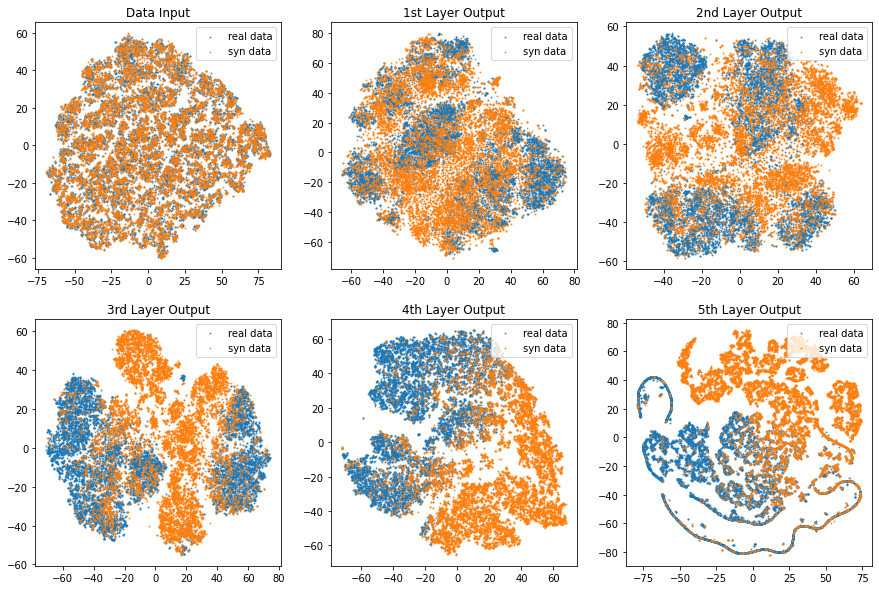

In [157]:
# plot

plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.figure()


plt.subplot(2,3,1)
plt.scatter(act0_tsne[labels_[test][:20000] == 0, 0], act0_tsne[labels_[test][:20000] == 0, 1], s = 1, label = "real data", alpha=0.7) # real data
plt.scatter(act0_tsne[labels_[test][:20000] == 1, 0], act0_tsne[labels_[test][:20000] == 1, 1], s = 1, label = "syn data", alpha=0.7)
plt.legend(loc="upper right")
plt.title("Data Input")


plt.subplot(2,3,2)
plt.scatter(act1_tsne[labels_[test][:20000] == 0, 0], act1_tsne[labels_[test][:20000] == 0, 1], s = 1, label = "real data", alpha=0.7) # real data
plt.scatter(act1_tsne[labels_[test][:20000] == 1, 0], act1_tsne[labels_[test][:20000] == 1, 1], s = 1, label = "syn data", alpha=0.7)
plt.legend(loc="upper right")
plt.title("1st Layer Output")


plt.subplot(2,3,3)
plt.scatter(act2_tsne[labels_[test][:20000] == 0, 0], act2_tsne[labels_[test][:20000] == 0, 1], s = 1, label = "real data", alpha=0.7) # real data
plt.scatter(act2_tsne[labels_[test][:20000] == 1, 0], act2_tsne[labels_[test][:20000] == 1, 1], s = 1, label = "syn data", alpha=0.7)
plt.legend(loc="upper right")
plt.title("2nd Layer Output")

plt.subplot(2,3,4)
plt.scatter(act3_tsne[labels_[test][:20000] == 0, 0], act3_tsne[labels_[test][:20000] == 0, 1], s = 1, label = "real data", alpha=0.7) # real data
plt.scatter(act3_tsne[labels_[test][:20000] == 1, 0], act3_tsne[labels_[test][:20000] == 1, 1], s = 1, label = "syn data", alpha=0.7)
plt.legend(loc="upper right")
plt.title("3rd Layer Output")

plt.subplot(2,3,5)
plt.scatter(act4_tsne[labels_[test][:20000] == 0, 0], act4_tsne[labels_[test][:20000] == 0, 1], s = 1, label = "real data", alpha=0.7) # real data
plt.scatter(act4_tsne[labels_[test][:20000] == 1, 0], act4_tsne[labels_[test][:20000] == 1, 1], s = 1, label = "syn data", alpha=0.7)
plt.legend(loc="upper right")
plt.title("4th Layer Output")

plt.subplot(2,3,6)
plt.scatter(act5_tsne[labels_[test][:20000] == 0, 0], act5_tsne[labels_[test][:20000] == 0, 1], s = 1, label = "real data", alpha=0.7) # real data
plt.scatter(act5_tsne[labels_[test][:20000] == 1, 0], act5_tsne[labels_[test][:20000] == 1, 1], s = 1, label = "syn data", alpha=0.7)
plt.legend(loc="upper right")
plt.title("5th Layer Output")


plt.show()

## The code below tries to find which features really matter in training
By checking the plots above, we find that after the 1st layer, the data are greatly decoupled, so we think the 1st layer makes a real difference.

To check which feature the 1st layer is detecting, we get inspiration from the paper "Zeiler M.D., Fergus R. (2014) Visualizing and Understanding Convolutional Networks". We find the samples mostly active the 1st layer, then recover input by taking pseudo-inverse.

$A^{[1]} = Relu(WX + b)$,

So we can get $ X = W^{-1}(A^{[1]} - b)$, where $W^{-1}$means pseudo-inverse.



In [793]:
act1_argsort = np.argsort(act1, axis=0) # find the index of samples that mostly active the neurons in 1st layer

In [794]:
len(list(act1_argsort[-5:].flatten())) # for each neurons, find the 5th most active sample

300

In [795]:
act_samples = set(list(act1_argsort[-5:].flatten())) 

In [801]:
len(act_samples)

169

In [802]:
act_data = data_[test].copy()
act_data = act_data[list(act_samples), :]
act_data_labels = labels_[test].copy()[list(act_samples)]

In [805]:
act_out = act1[list(act_samples), :]

In [806]:
#act_out = np.matmul((act_out - model.intercepts_[4]), np.linalg.pinv(model.coefs_[4]))
#act_out = np.matmul((act_out - model.intercepts_[3]), np.linalg.pinv(model.coefs_[3]))
#act_out = np.matmul((act_out - model.intercepts_[2]), np.linalg.pinv(model.coefs_[2]))
#act_out = np.matmul((act_out - model.intercepts_[1]), np.linalg.pinv(model.coefs_[1]))
act_out = np.matmul((act_out - model.intercepts_[0]), np.linalg.pinv(model.coefs_[0]))

In [811]:
act_data_recover = act_out

In [ ]:
diff = -act_data.T + act_data_recover.T

# shows the distribution of diff
plt.hist(diff.flatten(), bins = 1000, density = True)
plt.show()
mask = diff < 0

# mask out those diff is < 0 (means these dimension are not so useful in the 1st layer beacuse they locate in x<0 in relu function)
diff[diff < 0] = 0
print(mask)
print(diff)

plt.show()
plt.imshow(diff, cmap='gray') 
plt.show()


In [832]:
# here we find important dimensions, 22 dimensions are chosen, shows below

print(np.sum(mask > 0, axis=1))


important_dims = np.where(np.sum(mask > 0, axis=1) >120)[0]
#important_dims = np.where(mask)[0]
print(important_dims.shape)
important_dims


[162  53 168 111 165  95 148  87 168 159 169 167 105 168  14 165 169  89
 158  99 108 148 126  32 110 157  50 113 136 148 135 169 169 169 169]
(22,)


array([ 0,  2,  4,  6,  8,  9, 10, 11, 13, 15, 16, 18, 21, 22, 25, 28, 29,
       30, 31, 32, 33, 34], dtype=int64)

In [834]:
important_dims2 = important_dims.copy()

## The code below find the most important combination of dimensions.

In [ ]:
# each time find 2 dimensions and train the model with only 2 dimension, print the combination with an accuracy > 0.6
# find that[25,29],[29,30],[25,30] is the most important dimensions.


for i in important_dims2:
    for j in important_dims2:
        if i == j:
            continue
        important_dims = [i, j]
        #mlp = MLPClassifier([60, 40, 20, 5], activation="relu", max_iter=500, verbose=True)
        mlp = MLPClassifier([60, 40, 20, 10, 5], activation="relu", max_iter=500, verbose=True)
        rf = RandomForestClassifier(max_depth = 10)
        svc = SVC(kernel = "rbf", verbose=True)

        # data and model


        data_2 = all_data[:, important_dims]
        labels_2 = labels

        #print(all_data.shape)
        #print(data_2.shape)
    

        kf = KFold(2, shuffle = True)
        acc_test_mlp2 = []
        acc_train_mlp2 = []

        for train2, test2 in kf.split(data_2):
            model2 = rf
            model2.fit(data_2[train2], labels_2[train2])
            out_train2 = model2.predict(data_2[train2])
            out_test2 = model2.predict(data_2[test2])
        
            acc_test_mlp2.append(np.sum(out_test2 == labels_2[test2]) / labels_2[test2].shape[0])
            acc_train_mlp2.append(np.sum(out_train2 == labels_2[train2]) / labels_2[train2].shape[0])
        
        if np.mean(acc_test_mlp2) > 0.6:
            print(important_dims)
        print(":::::" + str(j)) # just to show which step I am in
    print(i)

In [877]:
# train the model with only [25,29,30] and all other dimensions separately.
# to see if these 3 dimensions really matter
# the result is using [25,29,30] the accuracy is 72%, while using other is 74%
# so we can get a conclusion that these 3 dimensions really matter

important_dims = [ 0,  2,  4,  6,  8,  9, 10, 11, 13, 15, 16, 18, 21, 22, 28, 31, 32, 33, 34]
important_dims = [25, 29, 30]
#mlp = MLPClassifier([60, 40, 20, 5], activation="relu", max_iter=500, verbose=True)
mlp = MLPClassifier([60, 40, 20, 10, 5], activation="relu", max_iter=500, verbose=True)
rf = RandomForestClassifier()
svc = SVC(kernel = "rbf", verbose=True)

data_2 = all_data[:, important_dims]
labels_2 = labels

kf = KFold(2, shuffle = True)
acc_test_mlp2 = []
acc_train_mlp2 = []

for train2, test2 in kf.split(data_2):
    model2 = rf
    model2.fit(data_2[train2], labels_2[train2])
    out_train2 = model2.predict(data_2[train2])
    out_test2 = model2.predict(data_2[test2])
        
    acc_test_mlp2.append(np.sum(out_test2 == labels_2[test2]) / labels_2[test2].shape[0])
    acc_train_mlp2.append(np.sum(out_train2 == labels_2[train2]) / labels_2[train2].shape[0])

In [878]:
acc_test_mlp2

[0.7167297714205582, 0.7205160566540457]

In [879]:
acc_train_mlp2

[0.7205160566540457, 0.7167297714205582]

In [881]:
# get names of all dimensions 

col_names = []
for i in pd.concat([real_data, syn_data]).columns:
    if i in not_in_pc: 
        continue
    col_names.append(i)
np.array(col_names)

array(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'troglitazone',
       'examide', 'citoglipton', 'insulin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', '_diag_1', '_diag_2', '_diag_3'],
      dtype='<U24')

In [882]:
np.array(col_names)[important_dims] # print the name of these 3 important dimensions

array(['insulin', 'change', 'diabetesMed'], dtype='<U24')

## After finding these 3 dimensions, we check in which way these 3 dimensions of real data are different from the synthetic data.

In [915]:
real_data_3dim = data_2[labels == 0]
syn_data_3dim = data_2[labels == 1]

In [919]:
df_real = pd.DataFrame(real_data_3dim)
df_real.columns = ['insulin', 'change', 'diabetesMed']
df_real.corr() 

,insulin,change,diabetesMed
insulin,1.000000,-0.140689,0.262104
change,-0.140689,1.000000,-0.507413
diabetesMed,0.262104,-0.507413,1.000000


In [918]:
df_syn = pd.DataFrame(syn_data_3dim)
df_syn.columns = ['insulin', 'change', 'diabetesMed']
df_syn.corr()

,insulin,change,diabetesMed
insulin,1.000000,-0.018996,-0.00964
change,-0.018996,1.000000,0.02377
diabetesMed,-0.009640,0.023770,1.00000


## So finally we get to the conclusion

- The mainly difference between real data and synthetic data are dimensions “insulin”, “change” and “diabetesMed”;

- In real data, these three dimensions are highly related;

- while in synthetic data, these three dimensions seems to be generated independently.
